In [5]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [16]:
%load_ext autoreload
%autoreload 2
import cProfile
import importlib
import numpy as np
import os
import yaml
from generator import MCTS
from language import Language
from node import MolSentenceNode
from utils import add_sep, class_from_package, HELMConverter

config_path = "config/mcts_d_score_replication.yaml"
with open(os.path.join(repo_root, config_path)) as f:
    conf = yaml.safe_load(f)
    
model_class, model_dir, lang_path = (conf.get(k) for k in ("model_class", "model_dir", "lang_path"))
if lang_path is None:
    lang_name = os.path.basename(os.path.normpath(model_dir)) + ".lang"
    lang_path = add_sep(model_dir) + lang_name
lang = Language.load(os.path.join(repo_root, lang_path))
model_class = class_from_package("transition", model_class)
model = model_class(lang=lang, model_dir=os.path.join(repo_root, model_dir))

reward_class, reward_conf = (conf.get(k) for k in ("reward_class", "reward_conf"))
reward_conf = reward_conf or {}
reward_class = class_from_package("reward", reward_class)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class", "policy_conf"))
policy_class = class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = class_from_package("filter", s.pop("filter_class"))
    filters.append(filter_class(**s))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Search is started.
0- time: 0.00, reward: 0.4062820052555078, node: CC(C)(C)[C@@H](O)C[NH2+][C@@H]1CCC(C)(C#N)C1
1- time: 0.00, reward: 0.2255824872053715, node: CCN(Cc1ccc(F)c(O[C@@H]2CCCS2)c1)[C@H]1CCO1
2- time: 0.00, reward: 0.4145959736734996, node: CCN(Cc1ccc(C)nn1)Cc1ccc(C(=O)[O-])cc1
3- time: 0.50, reward: 0.0, node: O=C(OC(=O)Cn1cccc1F)N1CCC[C@@H]1[NH2+]Cc1ccccn1
4- time: 0.50, reward: 0.39611576458025005, node: O=C(NCc1cccnc1)O[C@H]1CCC[NH+](C2CCC2)C1
5- time: 1.03, reward: 0.2727338808458186, node: N#Cc1ccc(C(=O)NNc2cccc(C(F)F)c2)cc1
6- time: 1.03, reward: 0.4004837183599598, node: Nc1ccc([C@H]2CCCC[C@@H](c3ccccc3)[C@@H]2O)cc1
7- time: 1.49, reward: 0.0, node: c1cc(C)c(-c2ccc(N3CCc4cccc4=O)oc3c2)cc1Cl
8- time: 2.04, reward: 0.37264973993792155, node: Fc1ccc(CCS(=O)(=O)c2ccc3c(c2)OC[C@@H](C)C3)cc1
9- time: 2.04, reward: 0.0, node: FN(C(=O)c1nc(-c2ccccc2)no1)[C@@H]1COc2ccccc21
10- time: 2.63, reward: 0.0, node: [NH3+]Cc1cc(F)cc(C(=O)NC2CCC2)c1
11- time: 3.17, reward: 0.29851303

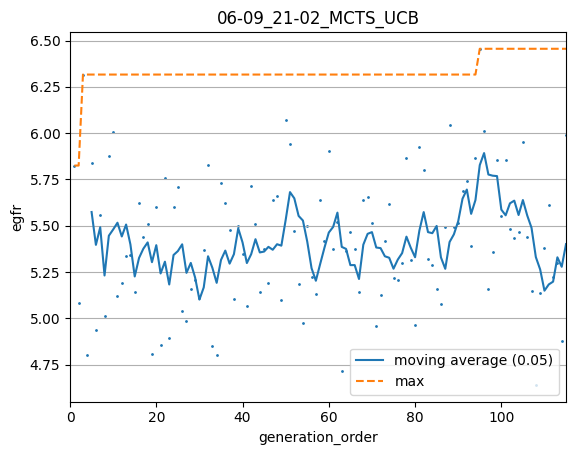

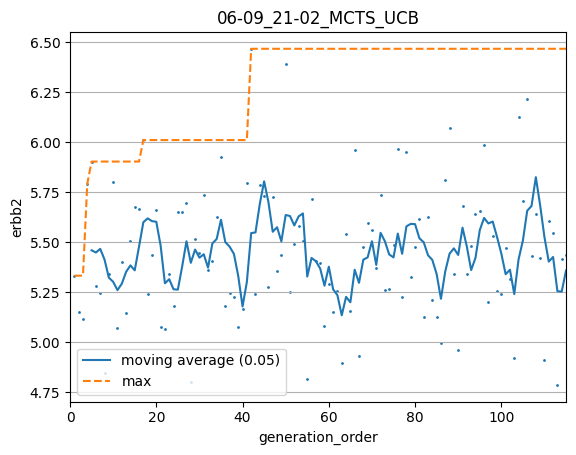

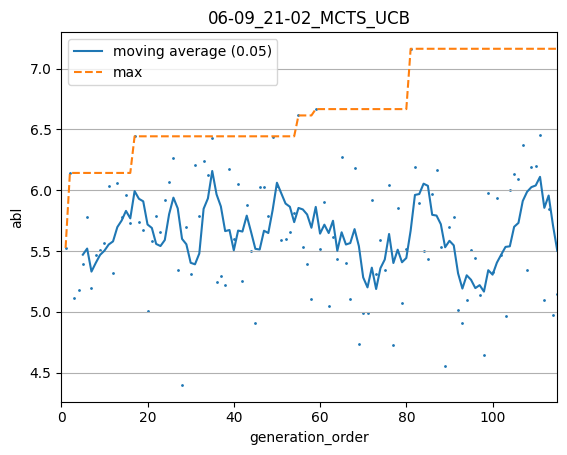

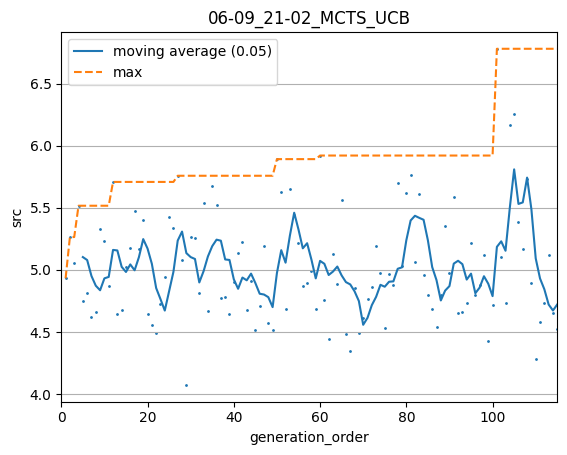

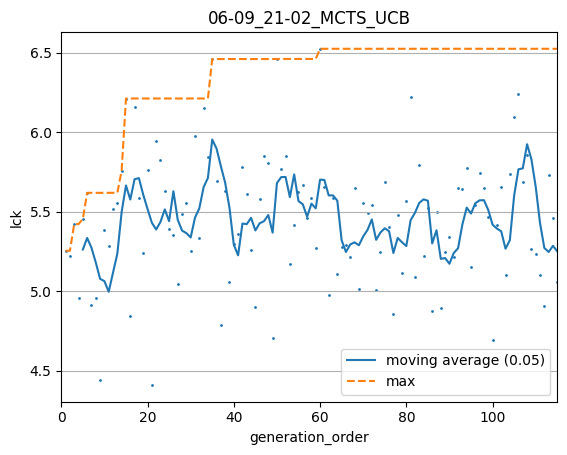

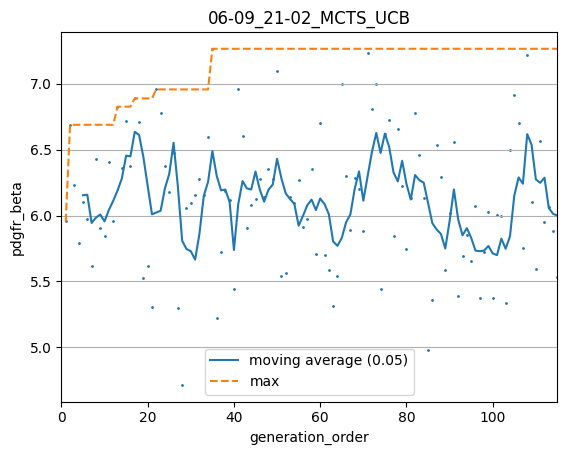

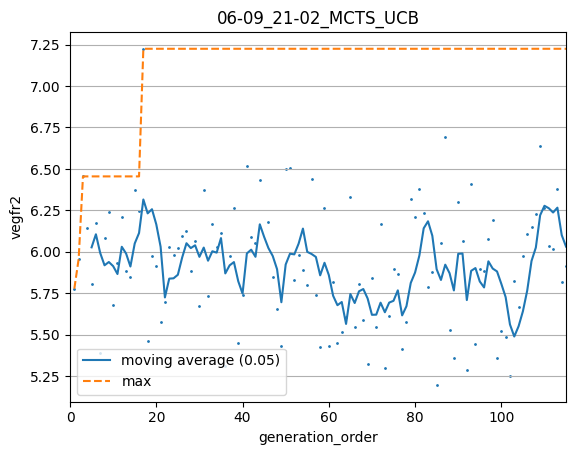

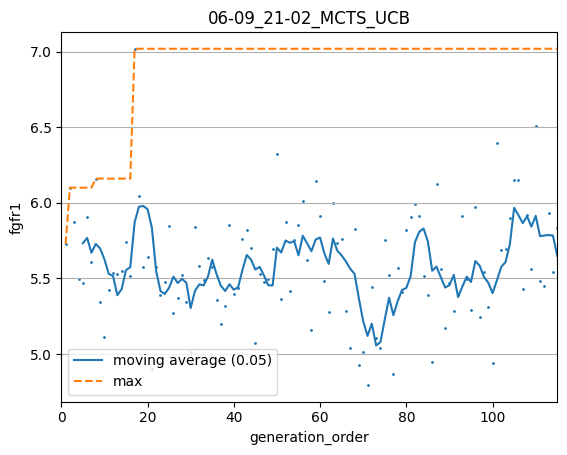

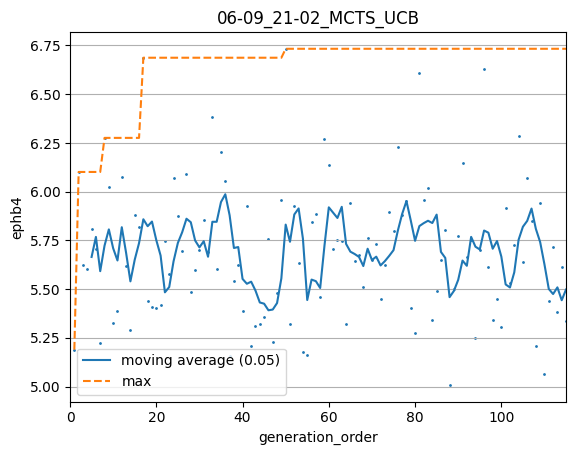

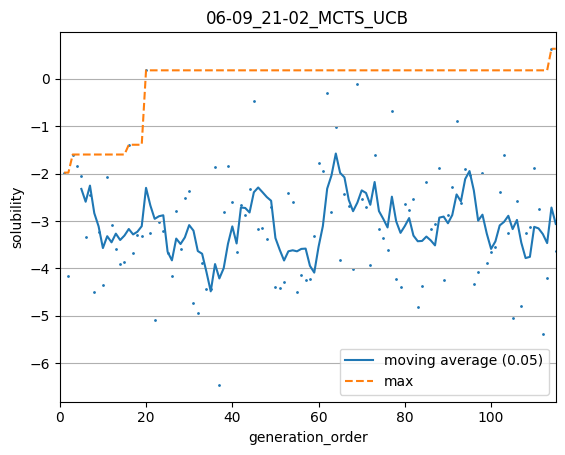

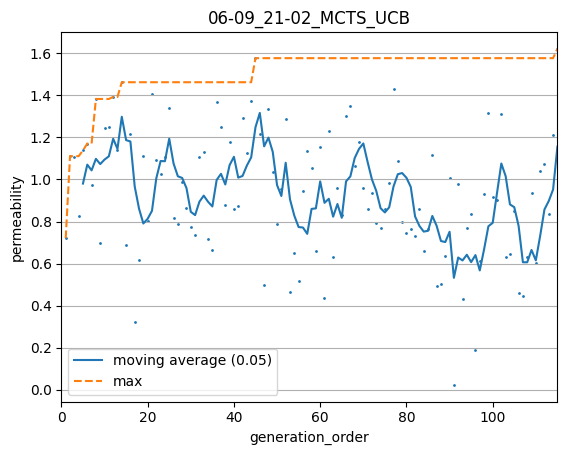

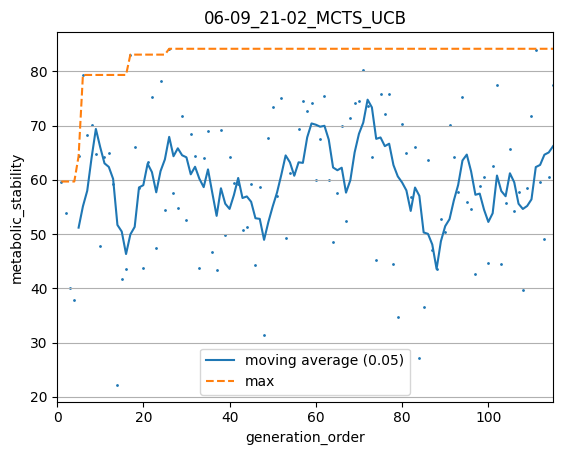

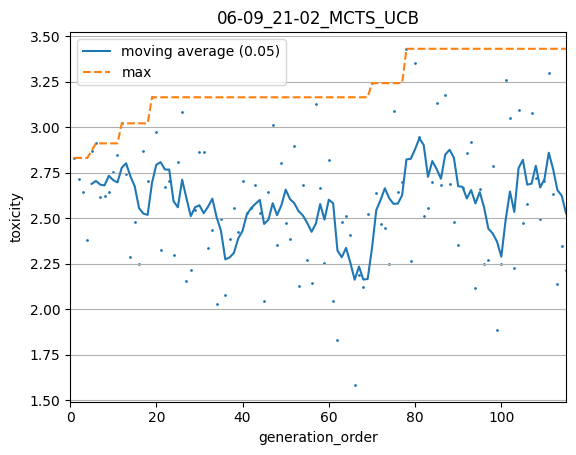

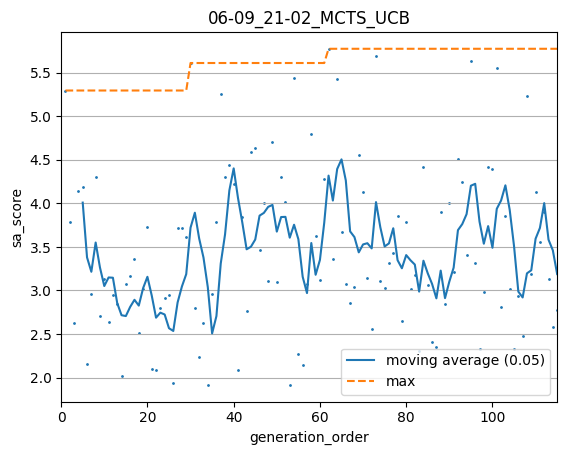

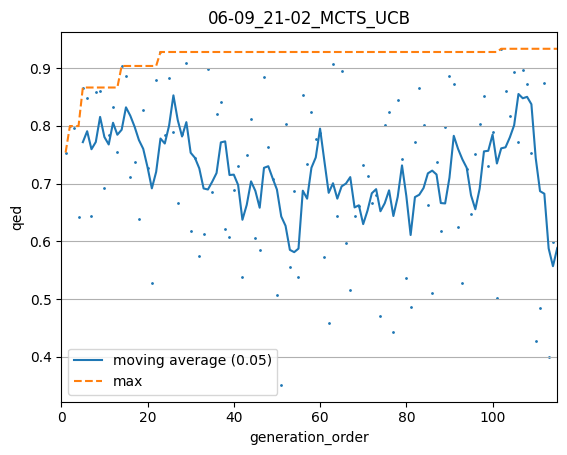

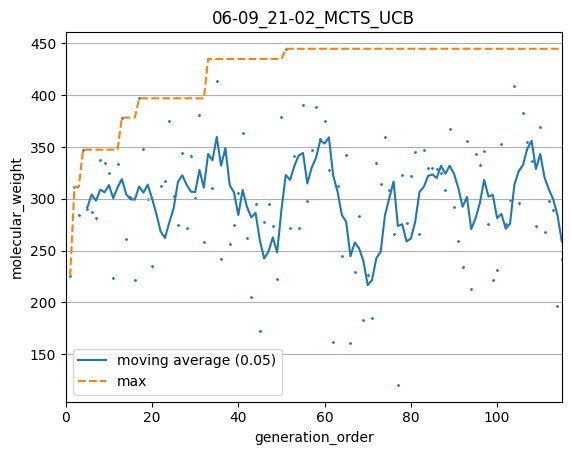

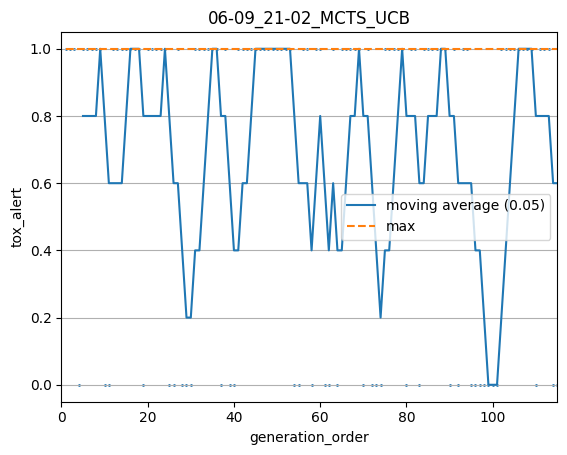

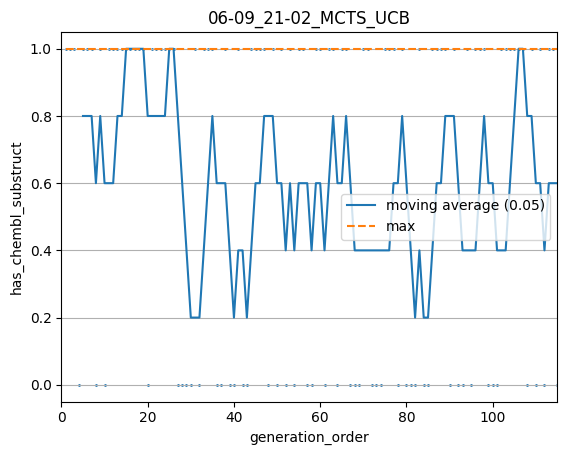

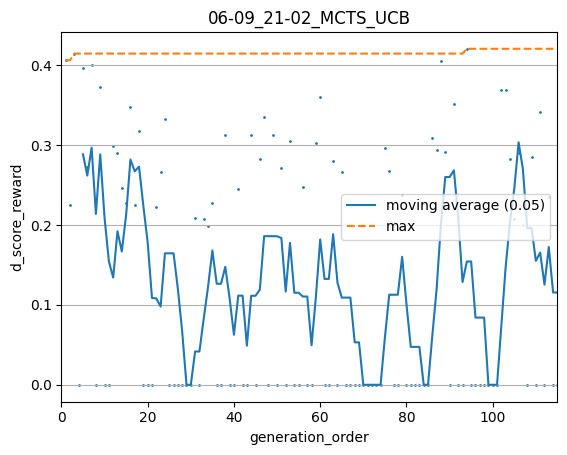

valid rate: 0.2904040404040404
node_per_sec: 1.9036925699067606


In [17]:
from rdkit import RDLogger
import shutil

RDLogger.DisableLog('rdApp.*') # invalid mols are already logged

root = MolSentenceNode.bos_node(lang) # TODO: change after root node generalization

output_dir, generator_conf, filtered_reward = (conf.get(k) for k in ("output_dir", "generator_conf", "filtered_reward"))
generator = MCTS(root=root, transition=model, reward=reward, policy=policy, filters=filters, filtered_reward=filtered_reward, output_dir=output_dir, **generator_conf)
src = os.path.join(repo_root, config_path)
dst = generator.output_dir() + "setting.yaml"
shutil.copy(src, dst)

time_limit, max_generations = (conf.get(k) for k in ("time_limit", "max_generations"))
generator.generate(time_limit=time_limit, max_generations=max_generations)
# cProfile.run("generator.generate(root=root, **generation_conf)"")

generator.plot_objective_values_and_reward(x_axis = "generation_order")
# generator.plot_objective_values_and_reward(x_axis = "time")
generator.analyze()

In [12]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [13]:
#load mcts
generator = MCTS.load(save_path, model)